In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import holtwinters
import statsmodels.api as sm
import seaborn as sns
import sklearn.linear_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')


#sns.set_style('white')

%matplotlib inline

/Users/stefano/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
Access_by_Site = pd.read_csv('Datasets/Access_by_Site.csv', parse_dates=['AccessDate'], index_col='AccessDate')

Access_by_Site.head(10)

,FRENSHAM,NORMANHURST,PYMBLE,SEVEN HILLS,THORNLEIGH,WENONA,TOTAL
AccessDate,,,,,,,
2009-03-07,0,89,0,0,0,0,89
2009-03-09,0,0,0,0,2,0,2
2009-03-10,0,14,0,0,14,0,28
2009-03-12,0,0,0,0,8,0,8
2009-03-14,0,9,0,0,0,0,9
2009-03-16,0,2,0,0,84,0,86
2009-03-17,0,16,0,0,1,0,17
2009-03-18,0,167,0,0,2,0,169
2009-03-21,0,108,0,0,0,0,108


# TIMESERIES ANALYSIS

---
 

---

## DEFINING MY CLASS

In [45]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error



class Forecaster:
    
    
    
    def __init__(self):
        pass
    
    
    
    def create_dataset(self):

        X = Access_by_Site.iloc[Access_by_Site[self.location].nonzero()[0][0]:][self.location].replace(0,1)
        X = pd.DataFrame(X.resample(self.frequency).sum())[:-self.yearly_coef/6]
        self.OA = X[-self.overlap:].fillna(0)[self.location] #Overlap Actual
        
        return X
        
    
    
    def fit_predict(self, location, frequency='M', forecast_periods=24, overlap=12,
                    ARIMA_grid=(12,1,1), SARIMAX_grid=(12,1,1,1,1,1), gridsearch=False):
    
        
        
        self.location = location
        self.frequency = frequency
        self.overlap = overlap
        self.forecast_periods = forecast_periods
        
        if frequency == 'M':
            self.yearly_coef = 12
            self.plot_coef = 4
            
            self.X = self.create_dataset()

            #PREDICTING 
            if gridsearch == False:
                self.ARIMA_grid = ARIMA_grid
                self.SARIMAX_grid = SARIMAX_grid
            elif gridsearch == True:
                self.ARIMA_grid = self.ARIMA_gridsearch()
                self.SARIMAX_grid = self.SARIMAX_gridsearch()
            else:
                raise ValueError('Invalid boolean value for gridsearch paramenter')


            self.HoltWinters = self.HoltWinters()

            self.ARIMA = self.ARIMA()

            self.SARIMAX = self.SARIMAX()

            self.ENSEMBLING = self.ENSEMBLING()

            self.outcome = pd.DataFrame({'Actual': self.X[self.location],'HOLT WINTERS': self.HoltWinters,'ARIMA': self.ARIMA,'SARIMAX': self.SARIMAX, 'ENSEMBLING': self.ENSEMBLING})

            #SCORING
            self.score()

            #VISUALIZATION
            self.plot()
        
        
        elif (frequency == 'W') or (frequency == 'D'):
            self.yearly_coef = 52
            self.plot_coef = 1
            
            self.X = self.create_dataset()
            
            if gridsearch == False:
                SARIMAX_grid_0 = SARIMAX_grid
                SARIMAX_grid_1 = (12,0,1,1,1,1)
                SARIMAX_grid_2 = (0,0,0,1,1,1)
            elif gridsearch == True:
                self.SARIMAX_grid = self.SARIMAX_gridsearch()
                SARIMAX_grid_0 = self.SARIMA_gridsearchFULL[0][0]
                SARIMAX_grid_1 = self.SARIMA_gridsearchFULL[0][1]
                SARIMAX_grid_2 = self.SARIMA_gridsearchFULL[0][2]
            else:
                raise ValueError('Invalid boolean value for gridsearch paramenter')


            
            self.SARIMAX_grid = SARIMAX_grid_0
            self.HoltWinters = self.SARIMAX()
            self.OP1 = self.HoltWinters[:self.overlap].fillna(0)
            
            self.SARIMAX_grid = SARIMAX_grid_1
            self.ARIMA = self.SARIMAX()
            self.OP2 = self.ARIMA[:self.overlap].fillna(0)
            
            self.SARIMAX_grid = SARIMAX_grid_2
            self.SARIMAX = self.SARIMAX()
            self.OP3 = self.SARIMAX[:self.overlap].fillna(0)
            
            self.ENSEMBLING = self.ENSEMBLING()

            self.outcome = pd.DataFrame({'Actual': self.X[self.location],'HOLT WINTERS': self.HoltWinters,'ARIMA': self.ARIMA,'SARIMAX': self.SARIMAX, 'ENSEMBLING': self.ENSEMBLING})

            #SCORING
            self.score()

            #VISUALIZATION
            self.plot()
            
        else:
            raise ValueError('Invalid value for frequency parameter')
        

    
    def HoltWinters(self):
        pred, _,_,_,_ = holtwinters.multiplicative(list(self.X[self.location][:-self.overlap]),self.yearly_coef,self.forecast_periods)
        
        predictions = pd.Series(data=pred, index=pd.date_range(self.X[-self.overlap:].index[0], freq=self.frequency, periods=self.forecast_periods))
        #predictions[predictions<0] = 0
        self.OP1 = predictions[:self.overlap].fillna(0) #Overlap Prediction 1
        
        return predictions
    
    
    
    def ARIMA(self):
        p,d,q = self.ARIMA_grid
        arima = ARIMA(self.X.diff().fillna(method='backfill').iloc[:-self.overlap], order=(p,d,q))
        model_fit = arima.fit()
        
        results = model_fit.forecast(steps=self.forecast_periods)
        pred = self.X[self.location][-self.overlap] + results[0].cumsum()
        
        predictions = pd.Series(data=pred, index=pd.date_range(self.X[-self.overlap:].index[0], freq=self.frequency, periods=self.forecast_periods))                       
        #predictions[predictions<0] = 0
        self.OP2 = predictions[:self.overlap].fillna(0) #Overlap Prediction 2
       
        return predictions
           
     
    
    def ARIMA_gridsearch(self):
        #Search for best optimal parameters
        results_dict = {}
        loop_range = [0,1,2,3,4]
        p = self.yearly_coef
        #for p in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
        for d in loop_range:
            for q in loop_range:
                try:
                    model = ARIMA(self.X.diff().fillna(method='backfill').iloc[:-self.overlap], order=(p,d,q))
                    fit = model.fit()
                    if np.isnan(fit.aic):
                        pass
                    else:
                        results_dict[((p,d,q))] = fit.aic
                        
                except ValueError:
                    pass
                except:
                    pass

        print "ARIMA gridsearch returned %d,%d,%d as best values"% results_dict.items()[0][0]
        return results_dict.items()[0][0]
       
        
    
    def SARIMAX(self):
        p,d,q,sp,sd,sq = self.SARIMAX_grid
        sarima = sm.tsa.statespace.SARIMAX(self.X[:-self.overlap], order=(p,d,q), seasonal_order=(sp,sd,sq,self.yearly_coef))
        model_fit = sarima.fit()
        pred = model_fit.get_forecast(steps=self.forecast_periods)
        self.conf_int = pred.conf_int(alpha=0.50)
        
        predictions = pd.Series(data=pred.predicted_mean, index=pd.date_range(self.X[-self.overlap:].index[0], freq=self.frequency, periods=self.forecast_periods))                       
        #predictions[predictions<0] = 0
        self.OP3 = predictions[:self.overlap].fillna(0) #Overlap Prediction 3
     
        return predictions
        
        
        
    def SARIMAX_gridsearch(self):
        #Search for best optimal parameters
        #results_dict = {}
        #loop_range = [0,1,2]
        #total_loops = len(loop_range) ** 6
        #start = 0
        for p in loop_range:
            for d in loop_range:
                for q in loop_range:
                    for sp in loop_range:
                        for sd in loop_range:
                            for sq in loop_range:
                                try:
                                    #print('SARIMAX grid search:', str(start), ' of ', str(total_loops))
                                    #start+=1
                                    model = sm.tsa.statespace.SARIMAX(self.X[:-self.overlap], order=(p,d,q), seasonal_order=(sp,sd,sq,self.yearly_coef))
                                    fit = model.fit()
                                    if np.isnan(fit.aic):
                                        pass
                                    else:
                                        results_dict[((p,d,q,sp,sd,sq))] = fit.aic

                                except ValueError:
                                    pass
                                except:
                                    pass
        
        self.SARIMA_gridsearchFULL = results_dict.items() #saving for weekly search
        print "SARIMA gridsearch returned %d,%d,%d,%d,%d,%d as best values"% results_dict.items()[0][0]
        return results_dict.items()[0][0]
 


    def ENSEMBLING(self):
        #regression to find perfect coefficent
        huber = sklearn.linear_model.HuberRegressor()
        en = pd.DataFrame({'Actual': self.OA,'HOLT WINTERS': self.OP1,'ARIMA': self.OP2,'SARIMAX': self.OP3})
        huber.fit(en[['HOLT WINTERS', 'ARIMA', 'SARIMAX']], en.Actual)
        self.huber_coef_ = huber.coef_
        c1,c2,c3 = huber.coef_
        
        predictions = (c1*self.HoltWinters + c2*self.ARIMA + c3*self.SARIMAX)
        #predictions = (0.5*self.ARIMA + 0.5*self.SARIMAX) # for THORNLEIGH and WEEKLY
        
        predictions[predictions<0] = 0
        self.OP4 = predictions[:self.overlap].fillna(0) #Overlap Prediciton 4
        
        return predictions
    

        
    def score(self):
        
        colors = ['b','g','r']
                   
        self.scores = pd.DataFrame({'Actual': self.OA,
                                    'HOLT WINTERS': self.OP1,'ARIMA': self.OP2,'SARIMAX': self.OP3, 'ENSEMBLING': self.OP4,
                                    'Error1': (self.OP1 - self.OA),'Error2': (self.OP2 - self.OA),'Error3': (self.OP3 - self.OA), 'Error4': (self.OP4 - self.OA)})#, index=actual.index)
        
 
        
        self.mean_absolute_error = [self.OA.mean(),
                                    mean_absolute_error(self.OA, self.OP1),
                                    mean_absolute_error(self.OA, self.OP2),
                                    mean_absolute_error(self.OA, self.OP3),
                                    mean_absolute_error(self.OA, self.OP4)]
        
        self.Growth2017 = (self.ENSEMBLING['2017'].mean() - self.X['2016'].mean()) / self.X['2016'].mean()
        #need to be fixed accordingly with elastic feutore predicting date
        self.Growth2018 = (self.ENSEMBLING['2018'].mean() - self.X['2017'].mean()) / self.X['2017'].mean()
    
        """
        self.mean_absolute_error = [self.OA.mean(),
                                    median_absolute_error(self.OA, self.OP1),
                                    median_absolute_error(self.OA, self.OP2),
                                    median_absolute_error(self.OA, self.OP3),
                                    median_absolute_error(self.OA, self.OP4)]
  
        """  
        
    def plot(self):
        
        fig, ax = plt.subplots(1, 2, figsize=(16,4))
        plot_acf(self.X.fillna(0), lags=self.yearly_coef*self.plot_coef, ax=ax[0])
        plot_pacf(self.X.fillna(0), lags=self.yearly_coef*self.plot_coef, ax=ax[1])

         
        fig,ax = plt.subplots(figsize=(16,9))
        ax.plot(self.outcome.Actual, c='black')
        ax.plot(self.outcome[['HOLT WINTERS','ARIMA','SARIMAX']], linestyle='dotted')
        ax.plot(self.outcome['ENSEMBLING'], c='r')
        plt.legend(['Actual','HOLT WINTERS','ARIMA','SARIMAX','ENSEMBLING'])
        
        confidence_intervals = self.conf_int
        #plt.fill_between(self.SARIMAX.index, confidence_intervals['lower ' + self.location],confidence_intervals['upper ' + self.location], color='lightsteelblue' )
        

        
        fig, ax = plt.subplots(1, 4, figsize=(16,4)) 
        
        ax[0].plot(self.scores[['Error1', 'Error2', 'Error3']], linestyle='dotted')
        ax[0].plot(self.scores['Error4'], c='r')
        ax[0].legend(['HOLT WINTERS','ARIMA','SARIMAX','ENSEMBLING'])
        #ax[0].xaxis.set_visible(False) #invisible
        plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)

        ax[1].plot(abs(self.scores[['Error1', 'Error2', 'Error3']]).cumsum(), linestyle='dotted')
        ax[1].plot(abs(self.scores['Error4']).cumsum(), c='r')
        ax[1].legend(['HOLT WINTERS','ARIMA','SARIMAX','ENSEMBLING'])
        plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90)

        ax[2].scatter(f.scores.Actual, f.scores['HOLT WINTERS'], s=3, c='b')
        ax[2].scatter(f.scores.Actual, f.scores.ARIMA, s=3, c='g')
        ax[2].scatter(f.scores.Actual, f.scores.SARIMAX, s=3, c='r')
        sns.regplot(f.scores.Actual, f.scores['ENSEMBLING'], color='r', ax=ax[2])# fit_reg=True
        #ax[2].scatter(f.scores.Actual, f.scores['ENSEMBLING'], s=15, c='r')
        #ax[2].legend(['HOLT WINTERS','ARIMA','SARIMAX','ENSEMBLING'])
        plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=90)

        sns.distplot(f.scores['Error1'], ax=ax[3], color='blue', rug=True, hist=False, kde_kws={'linestyle':'dotted', 'label':'HOLT WINTERS'}, axlabel=False)
        sns.distplot(f.scores['Error2'], ax=ax[3], color='green',rug=True, hist=False, kde_kws={'linestyle':'dotted', 'label':'ARIMA'}, axlabel=False)
        sns.distplot(f.scores['Error3'], ax=ax[3], color='r', rug=True, hist=False, kde_kws={'linestyle':'dotted', 'label':'SARIMAX'}, axlabel=False)
        sns.distplot(f.scores['Error4'], ax=ax[3], color='red', kde_kws={'label':'ENSEMBLING'}, axlabel=False)
        plt.setp(ax[3].xaxis.get_majorticklabels(), rotation=90)

       
        plt.show()
        
        print '\n'
        
        print "     The average entrie during the overlapping period is:  "  +'\033[1m'+ str(int(self.mean_absolute_error[0])) +'\033[0m'
        print "     The mean absolute error for the Holt Winter model in the overlapping period is:  " +'\033[1m' + str(int(self.mean_absolute_error[1])) +'\033[0m'
        print "     The mean absolute error for the ARIMA in the overlapping period is:  "  +'\033[1m'+ str(int(self.mean_absolute_error[2])) +'\033[0m'
        print "     The mean absolute error for the SARIMAX model in the overlapping period is:  "  +'\033[1m'+ str(int(self.mean_absolute_error[3])) +'\033[0m'
        print "     The mean absolute error for the ENSEMBLING model in the overlapping period is:  "  +'\033[1m'+ str(int(self.mean_absolute_error[4])) +'\033[0m'
        
        print '\n'
        
        print "     The predicted average growth from 2016 to 2017 is:  " '\033[1m'+ str(self.Growth2017)+'%'+'\033[0m'
        print "     The predicted average growth from 2017 to 2018 is:  " '\033[1m'+ str(self.Growth2018)+'%'+'\033[0m'


        
    

In [43]:
Access_by_Site.columns

Index([u'FRENSHAM', u'NORMANHURST', u'PYMBLE', u'SEVEN HILLS', u'THORNLEIGH',
       u'WENONA', u'TOTAL'],
      dtype='object')

# SEVEN HILLS

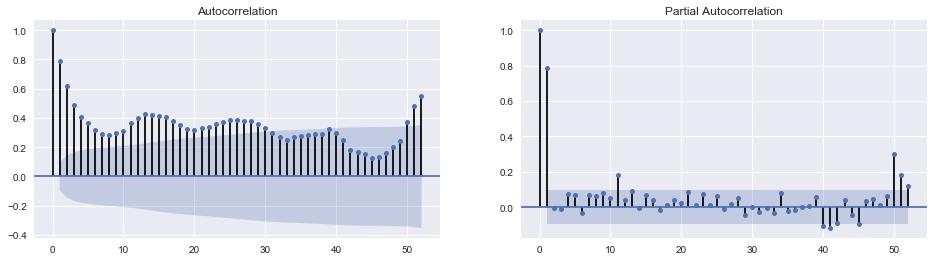

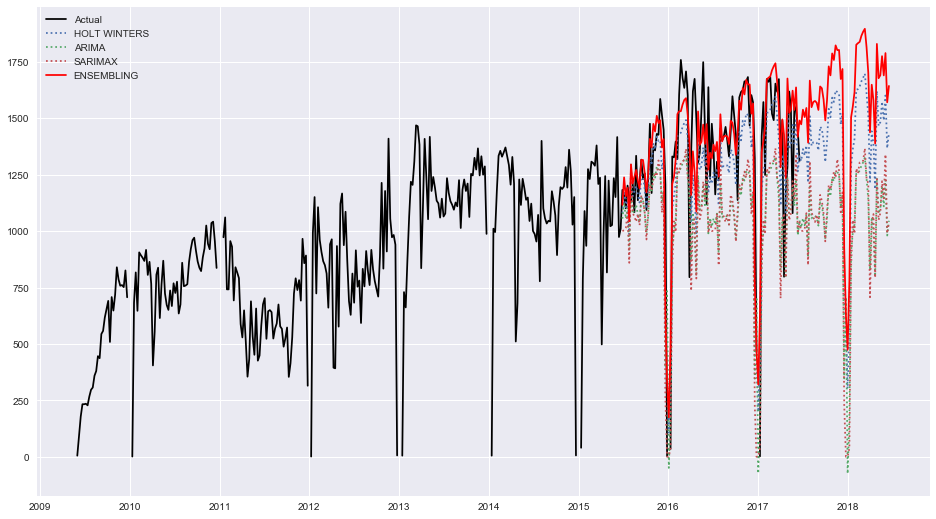

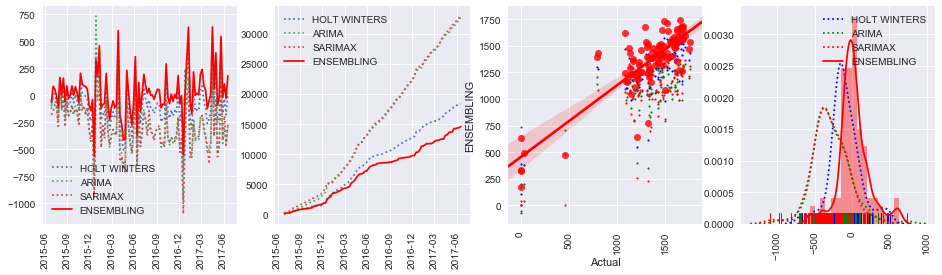



     The average entrie during the overlapping period is:  1332
     The mean absolute error for the Holt Winter model in the overlapping period is:  176
     The mean absolute error for the ARIMA in the overlapping period is:  314
     The mean absolute error for the SARIMAX model in the overlapping period is:  316
     The mean absolute error for the ENSEMBLING model in the overlapping period is:  140


     The predicted average growth from 2016 to 2017 is:  SEVEN HILLS    0.056198
dtype: float64%
     The predicted average growth from 2016 to 2018 is:  SEVEN HILLS    0.192834
dtype: float64%


In [44]:
f = Forecaster()
f.fit_predict('SEVEN HILLS', frequency='W', forecast_periods=156, overlap=104)

# PYMBLE

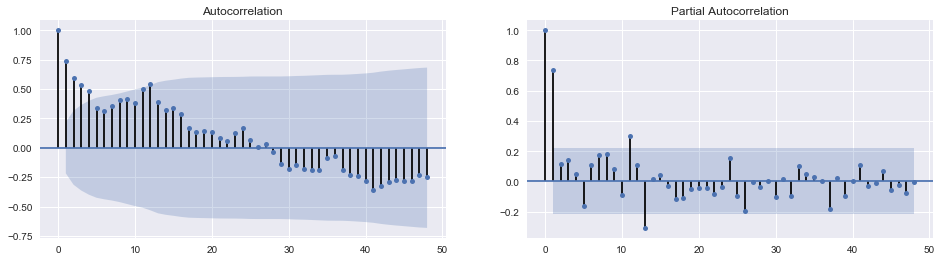

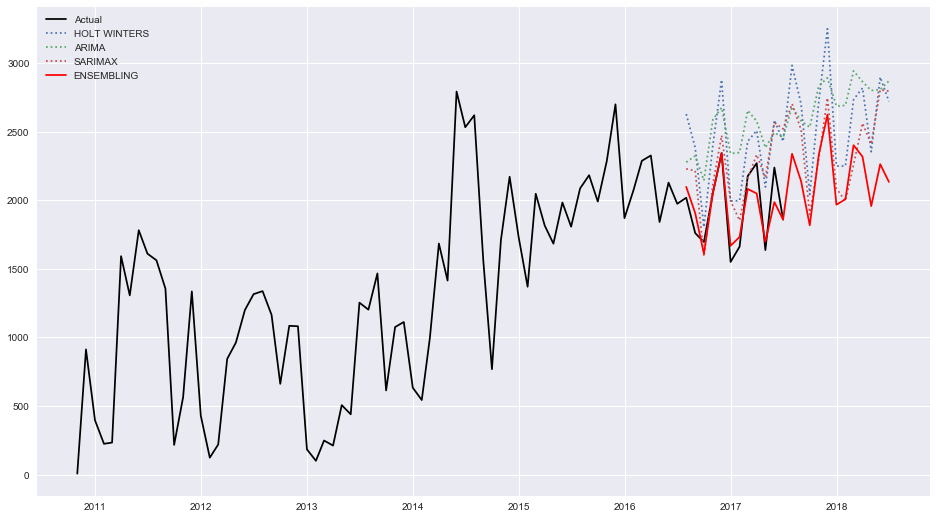

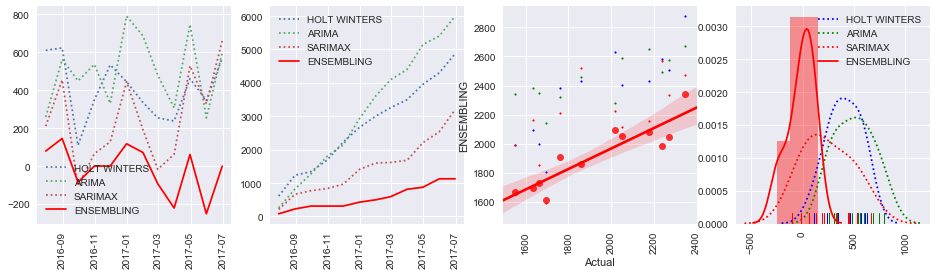



     The average entrie during the overlapping period is:  1938
     The mean absolute error for the Holt Winter model in the overlapping period is:  405
     The mean absolute error for the ARIMA in the overlapping period is:  499
     The mean absolute error for the SARIMAX model in the overlapping period is:  266
     The mean absolute error for the ENSEMBLING model in the overlapping period is:  93


     The predicted average growth from 2016 to 2017 is:  PYMBLE    0.023776
dtype: float64%
     The predicted average growth from 2016 to 2018 is:  PYMBLE    0.08765
dtype: float64%


In [34]:
f = Forecaster()
f.fit_predict('PYMBLE', ARIMA_grid=(12,0,0))#, SARIMAX_grid=(1,1,0,2,2,0))#, SARIMAX_grid=(1,1,0,2,2,0))


# NORMANHURST

In [152]:
#strugguling with Huber I am looking to overun it, 2 option

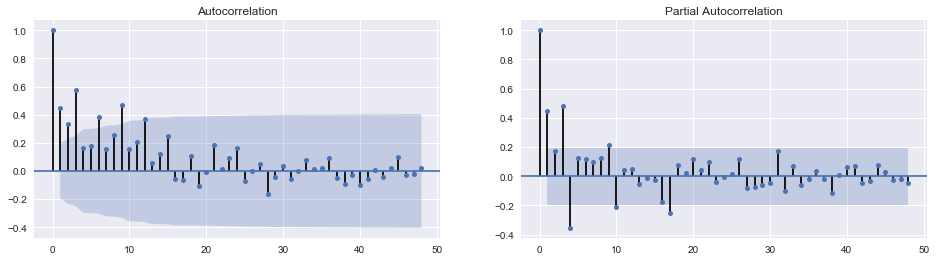

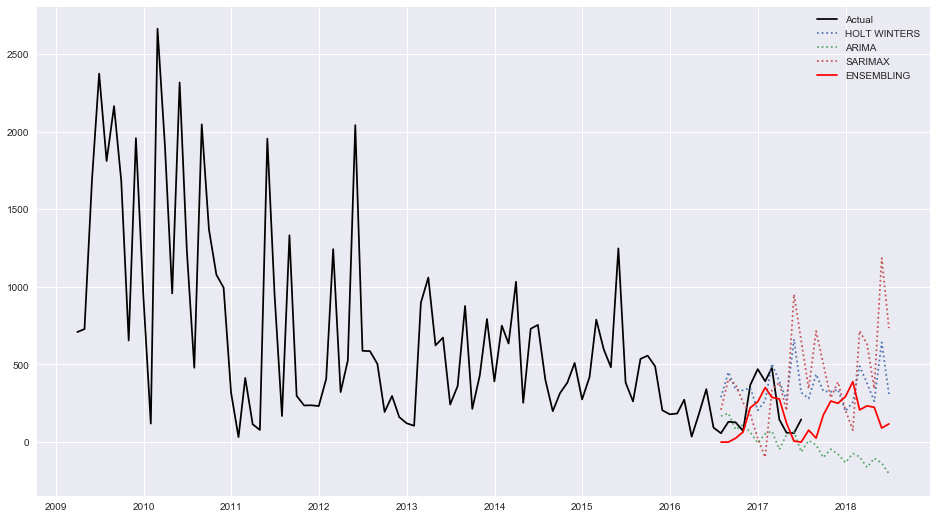

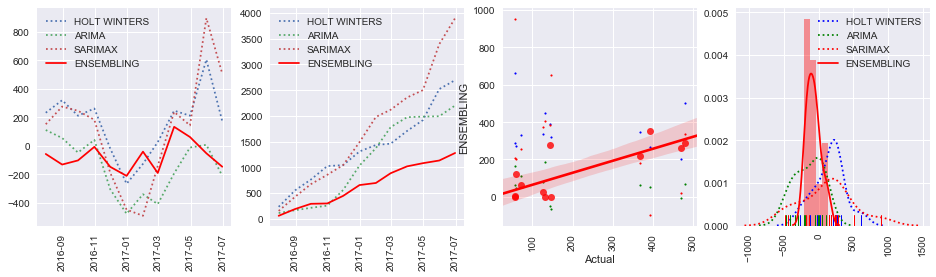



     The average entrie during the overlapping period is:  208
     The mean absolute error for the Holt Winter model in the overlapping period is:  224
     The mean absolute error for the ARIMA in the overlapping period is:  183
     The mean absolute error for the SARIMAX model in the overlapping period is:  324
     The mean absolute error for the ENSEMBLING model in the overlapping period is:  106


     The predicted average growth from 2016 to 2017 is:  NORMANHURST   -0.086807
dtype: float64%
     The predicted average growth from 2016 to 2018 is:  NORMANHURST    0.082577
dtype: float64%


In [37]:
f = Forecaster()
f.fit_predict('NORMANHURST', ARIMA_grid=(12,0,1), SARIMAX_grid=(12,0,1,1,1,1))

# THORNLEIGH

In [278]:
#HOLT WOLTERS wont work here so ensembeling method need to be fore to ignore it!! 3 Option

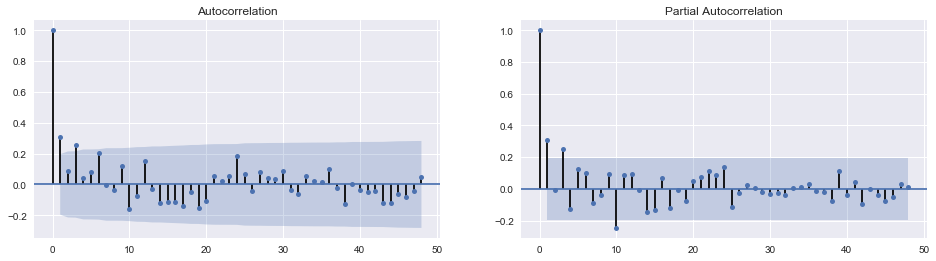

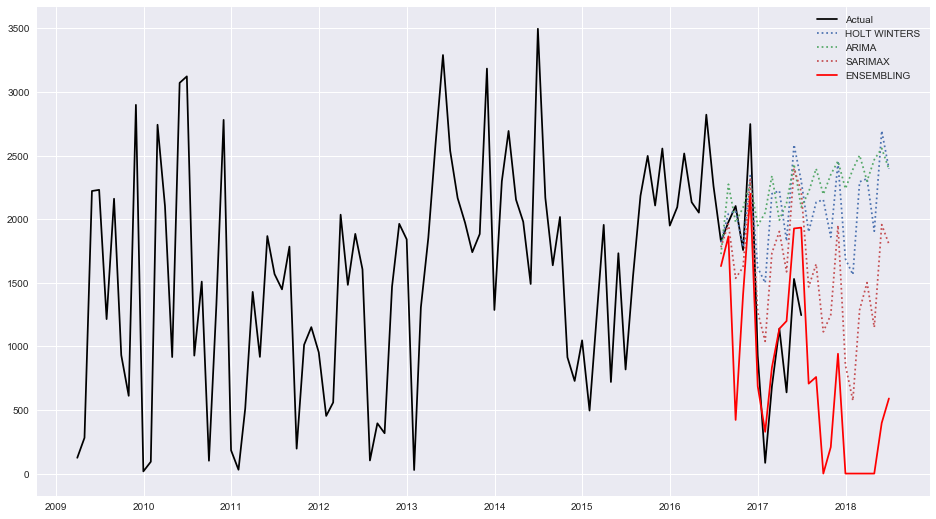

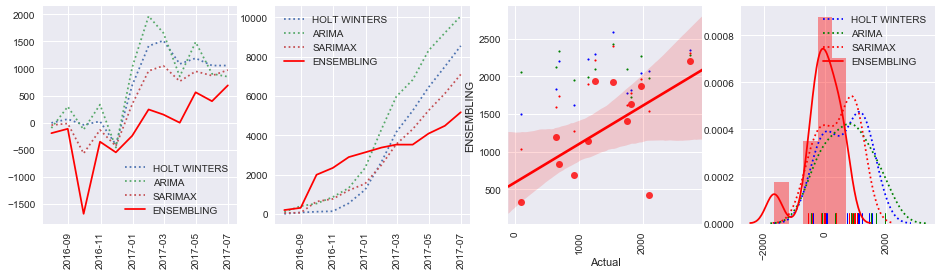



     The average entrie during the overlapping period is:  1387
     The mean absolute error for the Holt Winter model in the overlapping period is:  711
     The mean absolute error for the ARIMA in the overlapping period is:  837
     The mean absolute error for the SARIMAX model in the overlapping period is:  591
     The mean absolute error for the ENSEMBLING model in the overlapping period is:  430


     The predicted average growth from 2016 to 2017 is:  THORNLEIGH   -0.60432
dtype: float64%
     The predicted average growth from 2016 to 2018 is:  THORNLEIGH   -0.921631
dtype: float64%


In [36]:
f = Forecaster()
f.fit_predict('THORNLEIGH', ARIMA_grid=(12,0,1), SARIMAX_grid=(1,2,1,1,1,1))#, overlap=24, forecast_periods=36)#, ARIMA_grid=(12,0,1), , SARIMAX_grid=(1,2,1,1,1,1), overlap=24, forecast_periods=36)#, frequency='W',forecast_periods=208, overlap=52)


# FRENSHAM & WENONA

We don't have enough data

# TOTAL

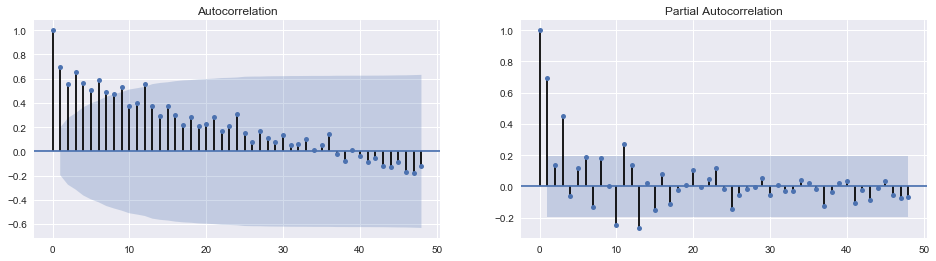

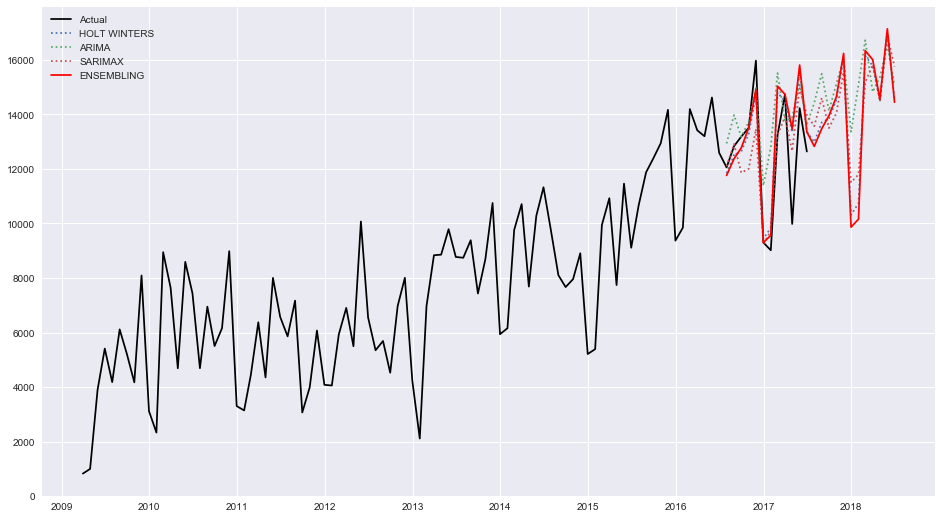

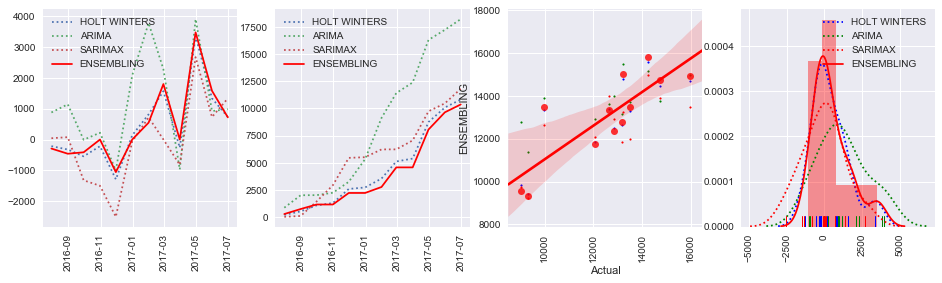



     The average entrie during the overlapping period is:  12559
     The mean absolute error for the Holt Winter model in the overlapping period is:  901
     The mean absolute error for the ARIMA in the overlapping period is:  1517
     The mean absolute error for the SARIMAX model in the overlapping period is:  983
     The mean absolute error for the ENSEMBLING model in the overlapping period is:  863


     The predicted average growth from 2016 to 2017 is:  TOTAL    0.053284
dtype: float64%
     The predicted average growth from 2017 to 2018 is:  TOTAL    0.200662
dtype: float64%


In [235]:
f = Forecaster()
f.fit_predict('TOTAL', ARIMA_grid=(12,0,1), SARIMAX_grid=(12,1,0,1,1,1))#, overlap=24, forecast_periods=36, SARIMAX_grid=(12,1,0,1,1,1), overlap=24

## TOTAL weekly

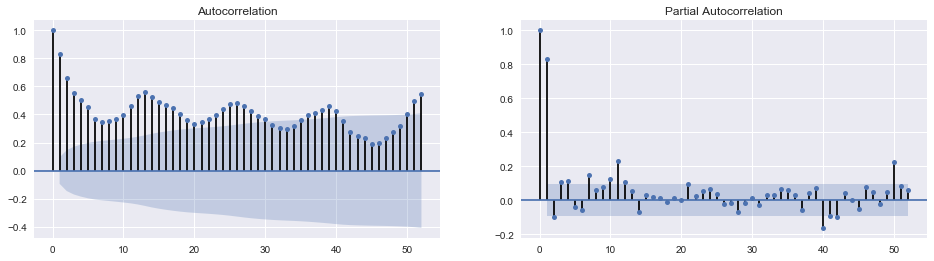

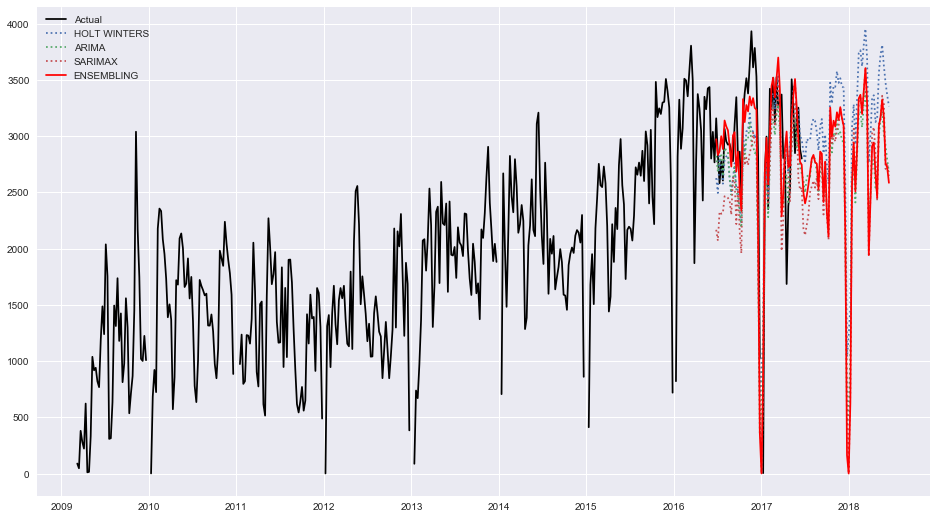

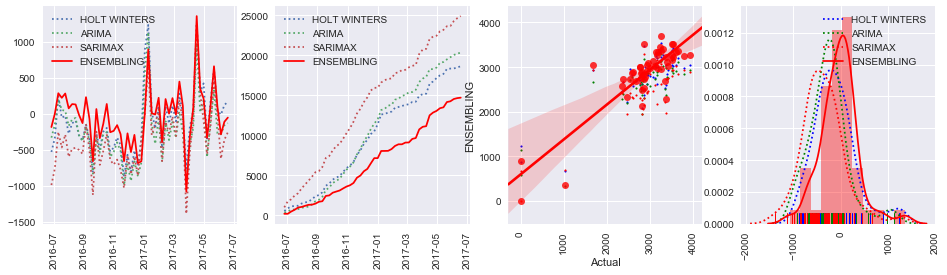



     The average entrie during the overlapping period is:  2894
     The mean absolute error for the Holt Winter model in the overlapping period is:  358
     The mean absolute error for the ARIMA in the overlapping period is:  391
     The mean absolute error for the SARIMAX model in the overlapping period is:  478
     The mean absolute error for the ENSEMBLING model in the overlapping period is:  282


     The predicted average growth from 2016 to 2017 is:  TOTAL   -0.109431
dtype: float64%
     The predicted average growth from 2017 to 2018 is:  TOTAL   -0.012196
dtype: float64%


In [218]:
#Holt & ARIMA don't really work weekly... therefore I am using 3 SARIMAX
f = Forecaster()
f.fit_predict('TOTAL', SARIMAX_grid=(1,1,0,1,1,1), frequency='W', forecast_periods=104, overlap=52)# gridsearch=True



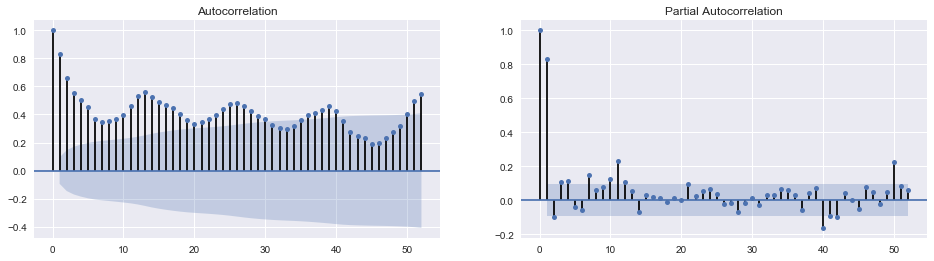

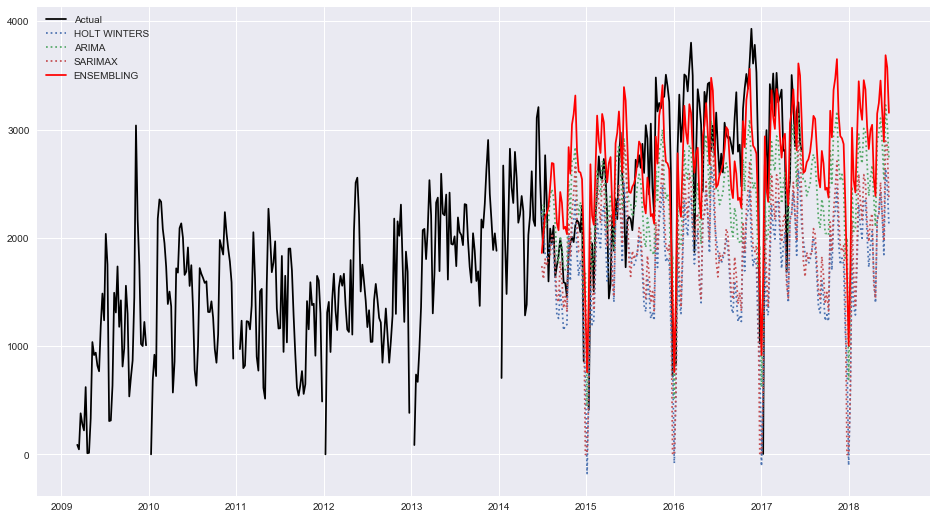

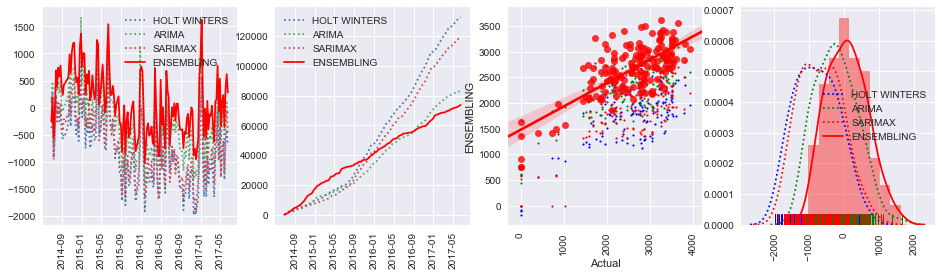



     The average entrie during the overlapping period is:  2560
     The mean absolute error for the Holt Winter model in the overlapping period is:  850
     The mean absolute error for the ARIMA in the overlapping period is:  531
     The mean absolute error for the SARIMAX model in the overlapping period is:  759
     The mean absolute error for the ENSEMBLING model in the overlapping period is:  472


     The predicted average growth from 2016 to 2017 is:  TOTAL   -0.08035
dtype: float64%
     The predicted average growth from 2017 to 2018 is:  TOTAL    0.052925
dtype: float64%


In [236]:
f = Forecaster()
f.fit_predict('TOTAL', SARIMAX_grid=(1,0,0,1,1,1), frequency='W', forecast_periods=208, overlap=156)# gridsearch=True
